# Phần 1. Problem Definition 
Project House Price Prediction nhằm xây dựng mô hình Machine Learning để dự đoán giá nhà dựa trên tập dữ.

Ta thực hiện bằng cách phân tích, xử lý dữ liệu và thử nghiệm các thuật toán hồi quy : Linear Regression, Lasso Regression, Random Forest. 

# Phần 2 : Import thư viện & đọc dữ liệu

#### Import Libraries


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Load Datasets 

In [139]:
# Nạp data vào train ( để huấn luyện) và test (để test mô hình )
df = pd.read_csv("train.csv")
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Kiểm tra Shape của Dataset 

In [140]:
print(df.shape)

(1460, 81)


### Data Spliting X,y : Chia ra 2 tập Features và Key 



In [141]:
X = df.drop(['Id','SalePrice'], axis=1)
y = df['SalePrice']

# Phần 3 : Data Cleaning : Xử lý Missing Values

### a) Kiểm tra Missing Values tại các cột 

In [142]:
# Thống kê 20 cột có nhiều Missing Values nhất 
missing = X.isnull().sum()
missing_percent = (missing / len(X)) * 100
# Gộp lại thành DataFrame để tiện xem
missing_table = pd.DataFrame({
    'MissingValues': missing,
    'Percent': missing_percent
}).sort_values(by='Percent', ascending=False)

print(missing_table.head(20))

              MissingValues    Percent
PoolQC                 1453  99.520548
MiscFeature            1406  96.301370
Alley                  1369  93.767123
Fence                  1179  80.753425
MasVnrType              872  59.726027
FireplaceQu             690  47.260274
LotFrontage             259  17.739726
GarageQual               81   5.547945
GarageFinish             81   5.547945
GarageType               81   5.547945
GarageYrBlt              81   5.547945
GarageCond               81   5.547945
BsmtFinType2             38   2.602740
BsmtExposure             38   2.602740
BsmtQual                 37   2.534247
BsmtCond                 37   2.534247
BsmtFinType1             37   2.534247
MasVnrArea                8   0.547945
Electrical                1   0.068493
LandSlope                 0   0.000000


### b) Loại bỏ các cột có Missing value > 50% 

In [143]:
drop_cols = ['PoolQC','Alley','MiscFeature','Fence','MasVnrType']
X = X.drop(columns=drop_cols)

### c) Thay thế Missing values trong các cột Numeric và Categorical 

In [144]:
# Tách ra Feature dạng Numeric và Categorical
from sklearn.impute import SimpleImputer
X_num = X.select_dtypes(include=['int64','float64'])
X_cat = X.select_dtypes(include=['object'])

In [145]:
# Thay thế với các cột Numeric 
imputer = SimpleImputer(strategy='mean')
X_num = pd.DataFrame(
    imputer.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)
X_num.shape 


(1460, 36)

In [146]:
# Thay thế các cột Categorical 
imputer = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(
    imputer.fit_transform(X_cat),
    columns=X_cat.columns,
    index=X_cat.index
)
X_cat.shape

(1460, 38)

# Phần 4 : EDA (Exploratory Data Analysis) 

## 1. EDA với Numeric Feature 

### a) Vẽ Hisplot : Khảo sát cách Dữ liệu phân bố tại các Numeric Features 

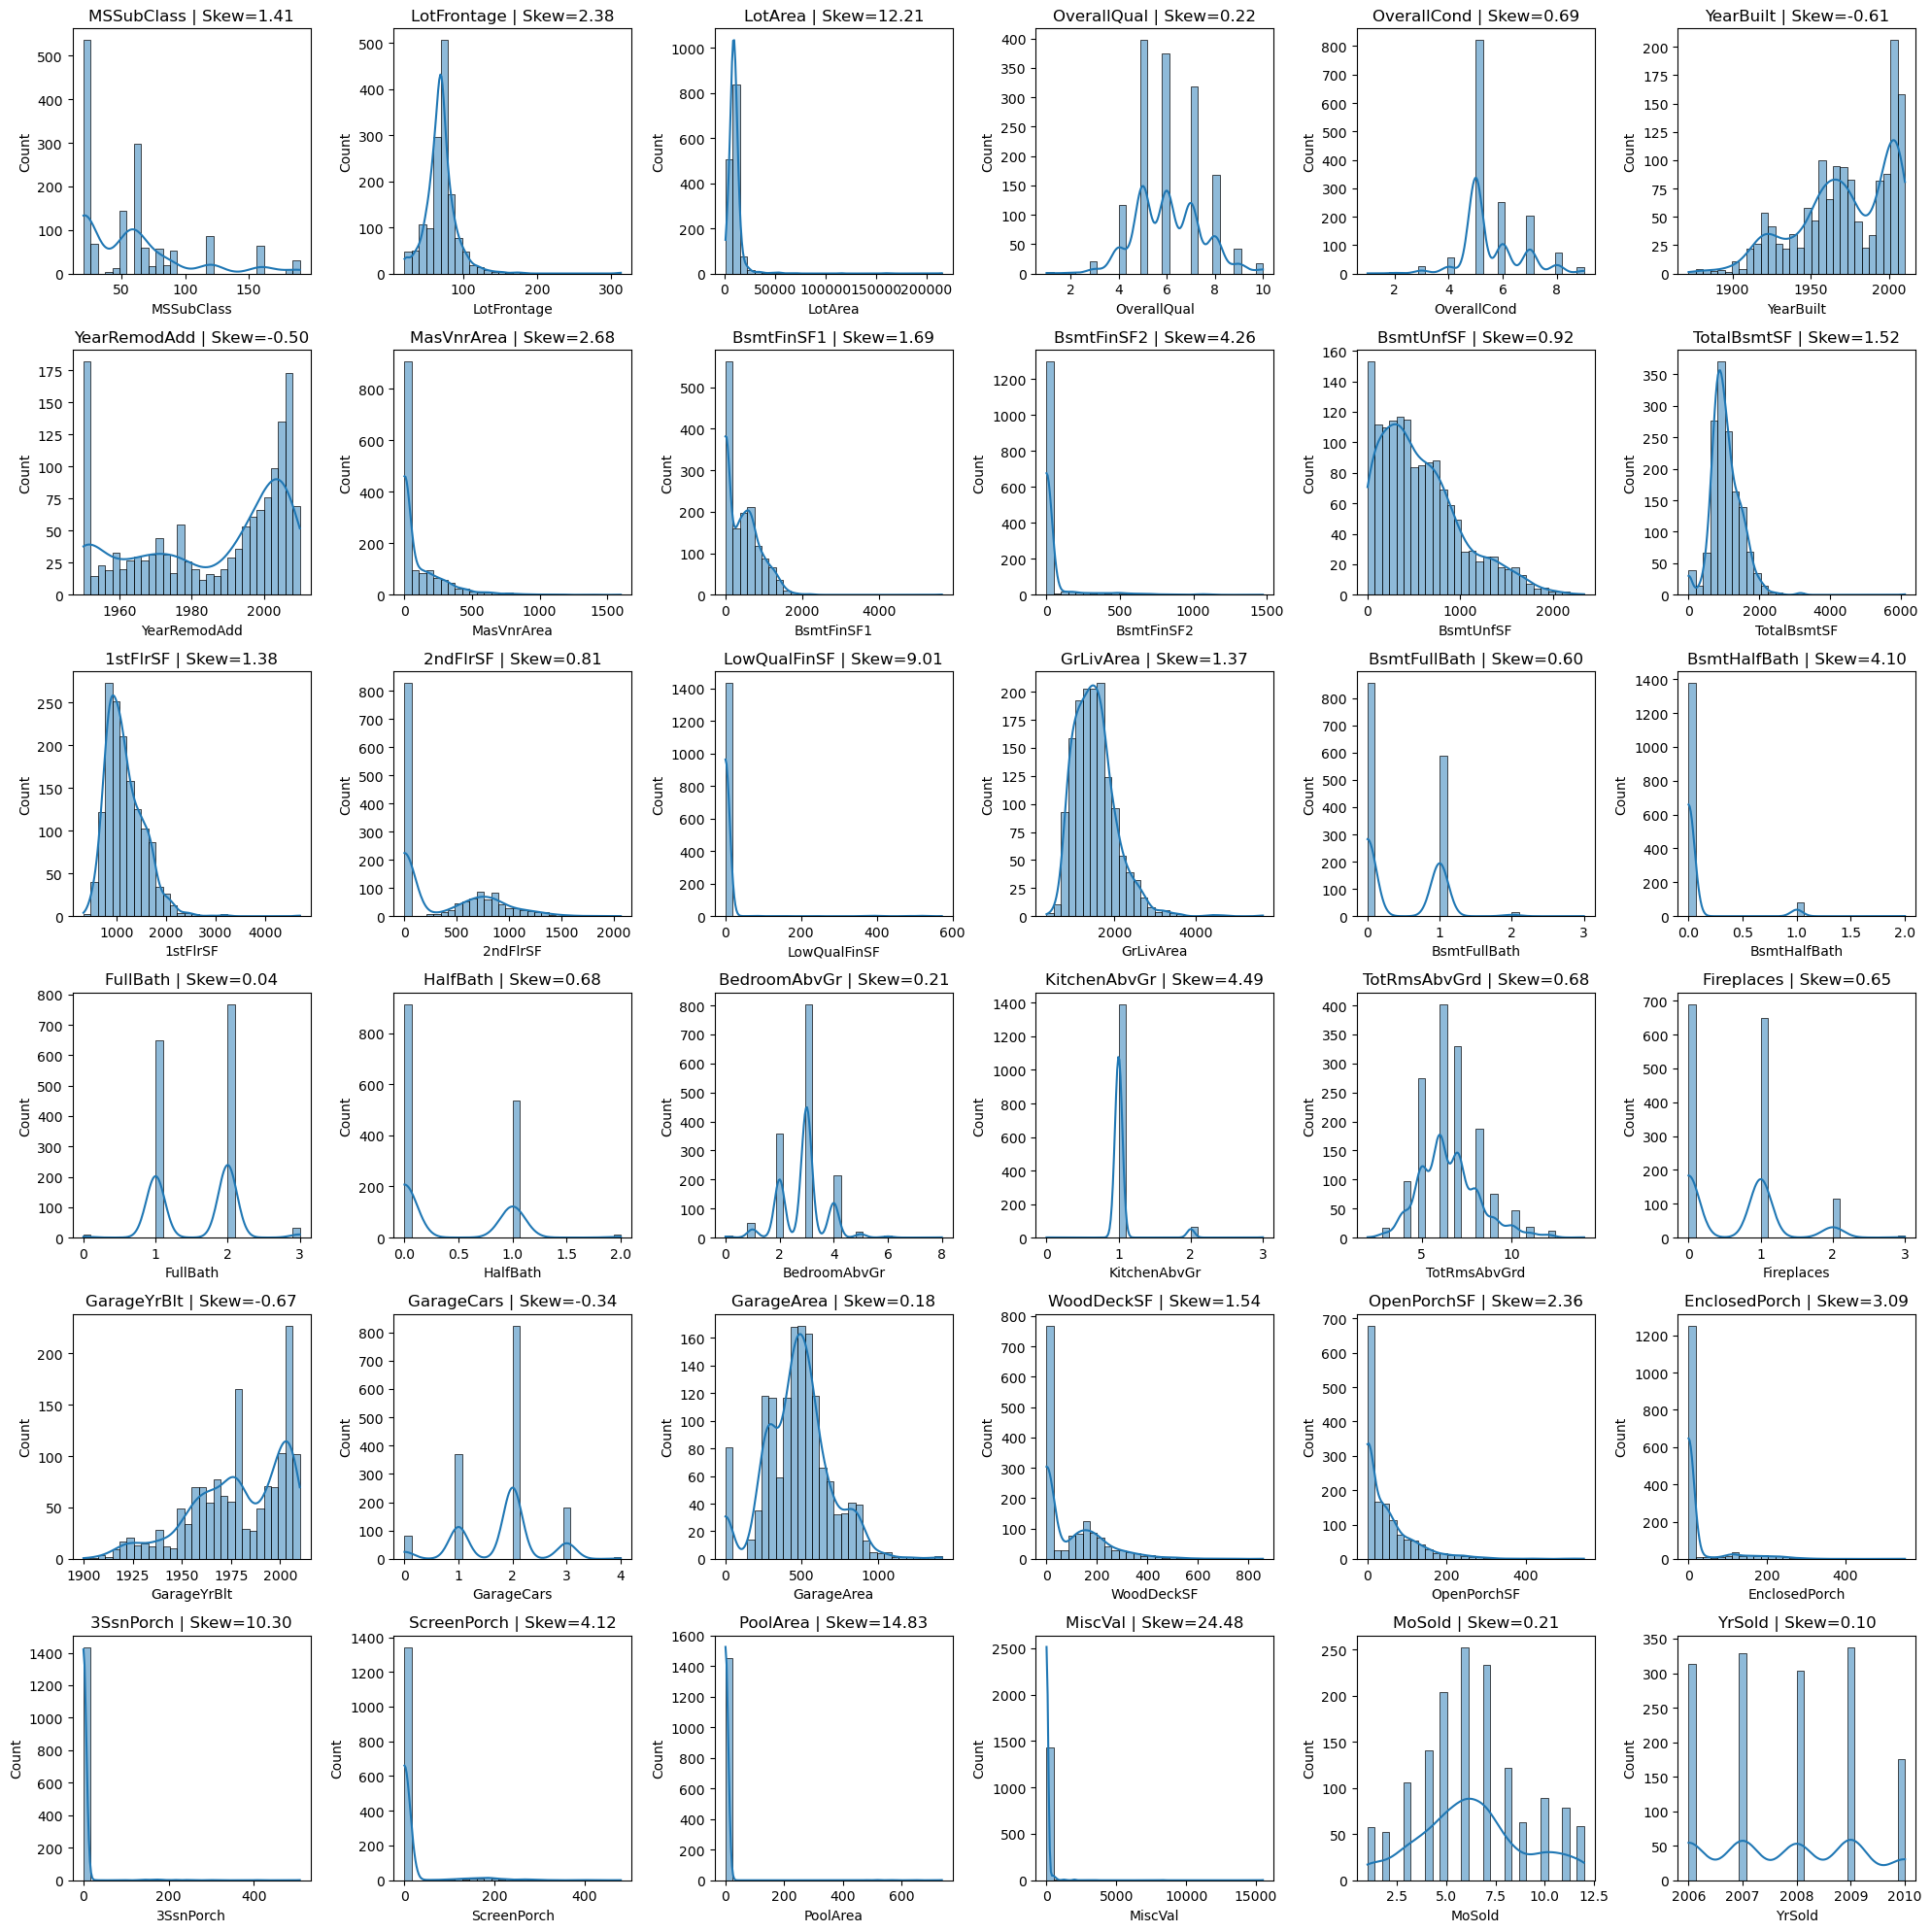

In [147]:
fig, axes = plt.subplots(6,6,figsize=(20,20))
for col, ax in zip(X_num.columns, axes.ravel()):
    sns.histplot(X_num[col], kde=True, bins=30, ax=ax)
    ax.set_title(f"{col} | Skew={X_num[col].skew():.2f}")
plt.tight_layout(); plt.show()

#### VẤN ĐỀ : Các cột có chứa outliers và skew lớn (>1) ---> Làm ảnh hưởng models dự đoán thiếu chính xác 

#### Ta sẽ loại bỏ outliers bằng clip và giảm skew bằng Log transform

In [148]:
# Clip theo percentile 1% - 99%  (để loại bỏ outlier) 
X_num = X_num.clip(lower=X_num.quantile(0.01),
                           upper=X_num.quantile(0.99),
                           axis=1)

# Log-transform ( Giảm skew) 
X_num = np.log1p(X_num)

### b) Heatmap : Kiểm tra Tương quan (corr) giữa các Feature  

#### Kiểm tra tương quan của các Numeric Features với Target

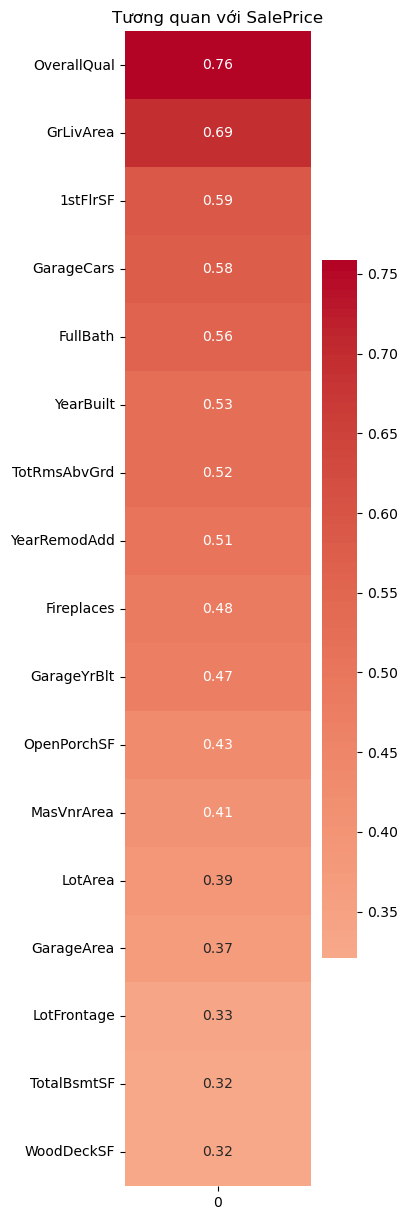

In [172]:
plt.figure(figsize=(3,15))
# Lấy corr của tất cả các Numeric Feature với Target (SalePrice)
sns.heatmap(X_num.corrwith(y).sort_values(ascending=False).to_frame(),
            annot=True, cmap="coolwarm", center=0)
plt.title("Tương quan với SalePrice")
plt.show()

### Feature Selection :

#### Ta chỉ giữ các Features có tương quan lớn với Target (SalePrice) và cắt bỏ Features có tương quan thấp


In [150]:
# Chỉ giữ lại Feature có |corr| > 0.3 với target 
selected_features = corr[abs(corr) >= 0.3].index
X_num = X_num[selected_features]

### d) Scale numeric features 

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X_num.columns,
    index=X_num.index
)
# X_scaled là dataframe Numeric Features sau khi được scaled

## 2. EDA với Categorical Features  

### a) Thay thế các labels ít xuất hiện
Ta cần gom tất cả các nhóm ít xhien thành 1 nhóm vì :
+ Giảm số chiều khi Encoding (do đã giảm số lượng labels ) 
+ Tránh overfitting vào những nhóm dữ liệu hiếm.

In [152]:
for col in X_cat.columns:
    freq = X_cat[col].value_counts(normalize=True)  
    # freq là 1 series chứa tần xuất , index là tên của các labels
    rare_labels = freq[freq < 0.01].index     
    # chọn ra tất cả các labels có fre < 0.01
    X_cat[col] = X_cat[col].replace(rare_labels, "other")
    # thay thế tất cả category trong rare labels bằng other

### B2 : Encoding 

In [153]:
X_encoded = pd.get_dummies(X_cat,drop_first=True,dtype=int)
# X_encoded là dataframe của categorical features sau khi được encoded

## 3. EDA cho Target  

Khảo sát phân bố dữ liệu : Kiểm tra outlier, skew

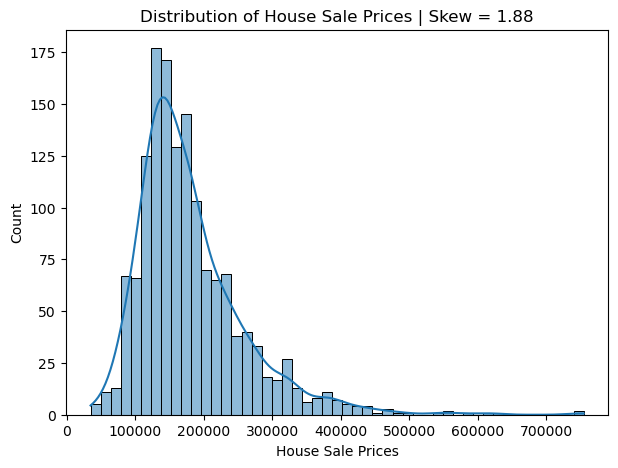

In [154]:
plt.figure(figsize=(7,5))
sns.histplot(y, kde=True)
plt.title(f"Distribution of House Sale Prices | Skew = {y.skew():.2f}")
plt.ylabel("Count")
plt.xlabel("House Sale Prices")
plt.show()


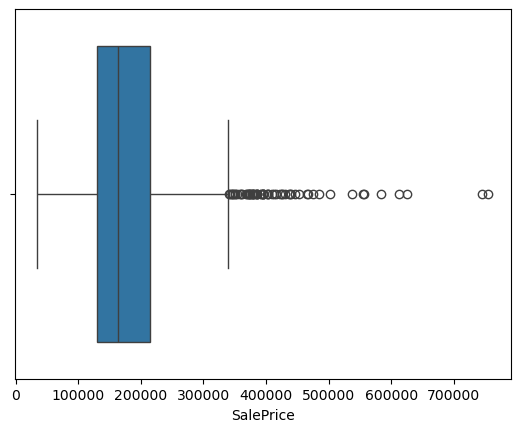

In [155]:
sns.boxplot(x=y)
plt.show()

Nhận xét : Có tồn tại outliers > 700000, tuy nhiên ta không nên loại bỏ outliers gây mất dữ liệu, thay vào đó ta nên sử dụng log transform để hạn chế ảnh hưởng của outliers, cũng như làm model dự đoán ổn định hơn

In [156]:
# log transform 
y_log = np.log1p(y)
print(y_log.skew())

0.12134661989685333


# Phần 5 : Chuẩn bị Data cho Training


#### Combination : Gộp 2 DF Numeric Features và Categorical Features thành 1 

In [157]:
X_final = pd.concat([X_scaled, X_encoded], axis=1)

#### Spliting : Chia ra làm 2 bộ data train và test với tỉ lệ 8/2

In [158]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_log, test_size=0.2)

# Phần 6 : Training model



## 1. Linear Regression 

#### Ở đây, vì đã xử lý xử lý skew, outliers , scale,... nên Linear Regression hoàn toàn có thể hoạt động ổn


In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Khởi tạo mô hình Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [160]:
y_pred = lin_reg.predict(X_test)
# Chuyển lại SalePrice về dạng giá tiền ban đầu (vì trước đó ta đã Log transform với y)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

#### Đánh giá với Metrics 

In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"MAE : {mae:,.2f}")
    print(f"MSE : {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:.4f}")
evaluate_regression(y_test_real,y_pred_real)

MAE : 16,785.32
MSE : 827,454,498.67
RMSE: 28,765.51
R²  : 0.8921


MAE ≈ 16,7k: trung bình mô hình dự đoán sai lệch khoảng 16,7k USD.
RMSE ≈ 28k: outlier làm sai số bình phương lớn.
R² ≈ 0.89: mô hình giải thích ~89% biến thiên giá nhà → khá tốt cho Linear

## 2. Lasso Regression

#### Vì dataset vẫn còn nhiều biến Onehot chưa được xử lý,chọn lọc nên ta sử dụng Lasso Regression để tự chọn lọc features quan trọng

In [162]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=42, max_iter=20000, n_jobs=-1)
lasso.fit(X_train, y_train)

LassoCV(cv=5, max_iter=20000, n_jobs=-1, random_state=42)

In [165]:
y_pred = lasso.predict(X_test)
# Chuyển lại SalePrice về dạng giá tiền ban đầu (vì trước đó ta đã Log transform với y)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

### Đánh giá với Metrics

In [166]:
evaluate_regression(y_test_real,y_pred_real)

MAE : 16,414.64
MSE : 853,834,375.09
RMSE: 29,220.44
R²  : 0.8887


MAE ≈ 16k → trung bình dự đoán lệch khoảng 16k USD nhưng với dữ liệu SalePrice (giá nhà thường từ 100k–500k), sai số này chấp nhận được
RMSE ≈ 29,220 → trung bình dự đoán lệch khoảng 29,2k USD : outliers làm RMSE lớn 
R² ≈ 0.889 → mô hình giải thích được gần 89% phương sai của giá nhà -->  fit khá tốt

## 3. Random Forest Regression

#### Random Forest Regressor là công cụ rất mạnh mẽ, ít bị ảnh hưởng bởi skew/outliers, rất phù hợp dữ liệu tabular

In [168]:
from sklearn.ensemble import RandomForestRegressor
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [169]:
y_pred = model_RFR.predict(X_test)
# Chuyển lại SalePrice về dạng giá tiền ban đầu (vì trước đó ta đã Log transform với y)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

### Đánh giá với Metric

In [170]:
evaluate_regression(y_test_real,y_pred_real)

MAE : 18,246.99
MSE : 887,198,411.22
RMSE: 29,785.88
R²  : 0.8843


MAE ≈ 18,247 → trung bình sai số tuyệt đối cao hơn 2 model đầu tiên 
RMSE ≈ 29,786 -> Tương đối lớn 
R² ≈ 0.884 → Fit khá ổn 

# So sánh các model : 

#### Lasso Regression hiện là model mạnh nhất  (RMSE thấp nhất, R² cao nhất).

#### Linear Regression cũng rất tốt, gần ngang ngửa Lasso.

#### Random Forest chưa hiệu quả trong setup hiện tại (do Random Forest phù hợp hơn với kiểu dữ liệu raw, còn Dataset đã được scale, Log transform,...)